<a href="https://colab.research.google.com/github/HammadN98/pytorch/blob/main/09_pytorch_deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. Deploy de Modelow

Pra q serve?

Para deixar o codigo que esta no notebook em algo usavel por outros/outra coisa.




## 0. Importando os basicos

* Pacotes
* E baixandos o going_modular do github

In [2]:
#ctrl c + ctrl v dos imports pardrao
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 31.83 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Baixando os dados

In [4]:
#ctrl c + ctrl v dos imports pardrao
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
#ctrl c + ctrl v dos imports pardrao
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. Experimentos para o Deploy do FoodVisiob Mini

### 3 Perguntas a serem respondidas?

1. QUal o melhor cenario para o deploy desse modeelo de machine learning?
2. Para aondemeu modelo ira?
3. Como o modelo ira funcionar?

**USo ideal do FoodVision Mini:**  Um modelo que performa bem e seeja rapido
  1. PErformace: 95%+ de acurácia
  2. Rapdo: O mais perto de real-time possivel (30FPS+ ou 30ms de latencia)

Para conseguir sses objetivos serao realizados eexperimentos em dois modelos:
  1. EffNetBB2
  2. ViT  

## 3. Criando um extrator de caracteristicas EffNetB2

extrator de caracteristicas = Um termo para "transer learning", aonde o modelo tem suas camadas bases congeladas e saida customizada para o problema em questao.

In [6]:
#PEgando os pesos
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

#PEgando os transforms
efnetb2_transforms = effnetb2_weights.transforms()

#Instanciando um model effnet com os pesos DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

#COngelando as camadas baes
for param in effnetb2.parameters():
 param.requires_grad=False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 96.6MB/s]


In [7]:
from torchinfo import summary

 # Print EffNetB2 model summary (uncomment for full output)
saidas = summary(effnetb2,
         input_size=(1, 3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])
#saidas

In [8]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
set_seeds()
effnetb2.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408, out_features=3))

In [10]:
 # Print EffNetB2 model summary (uncomment for full output)
saidas2 = summary(effnetb2,
         input_size=(1, 3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])
saidas2

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Criando uma funcao para criar um modelo de extracao de caracteristicas EffNetB2

In [11]:
def create_effnetb2(num_classes:int = 3,
                    seed:int=3):

  # Pesos, transforms, e instanciando o modelo
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  #COngelando as camdas base
  for param in model.parameters():
    requires_grad=False

  #AJustando o classifier para o problema em questao
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=3))

  return model, transforms

In [12]:
effnetb2, effnetb2_transforms = create_effnetb2(num_classes=3, seed=42)

In [13]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## COnfigurando Dataloaders pra o EffNetB2


In [15]:
from going_modular.going_modular import data_setup

train_datalaoder_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [16]:
len(train_datalaoder_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### Treinado o extrator de caracteristicas EffNetB2

In [17]:
from going_modular.going_modular import engine
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)

modelo = engine.train(model=effnetb2,
                      train_dataloader=train_datalaoder_effnetb2,
                      test_dataloader=test_dataloader_effnetb2,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4206 | train_acc: 0.8438 | test_loss: 0.2969 | test_acc: 0.9125
Epoch: 2 | train_loss: 0.1538 | train_acc: 0.9313 | test_loss: 0.0888 | test_acc: 0.9563
Epoch: 3 | train_loss: 0.1798 | train_acc: 0.9458 | test_loss: 0.0837 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.4032 | train_acc: 0.9292 | test_loss: 0.1415 | test_acc: 0.9477
Epoch: 5 | train_loss: 0.0964 | train_acc: 0.9854 | test_loss: 0.1850 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.1712 | train_acc: 0.9354 | test_loss: 0.1888 | test_acc: 0.9506
Epoch: 7 | train_loss: 0.2174 | train_acc: 0.9479 | test_loss: 0.1973 | test_acc: 0.9324
Epoch: 8 | train_loss: 0.1194 | train_acc: 0.9542 | test_loss: 0.1274 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.1551 | train_acc: 0.9625 | test_loss: 0.2542 | test_acc: 0.9108
Epoch: 10 | train_loss: 0.1214 | train_acc: 0.9583 | test_loss: 0.3546 | test_acc: 0.8557


### 3.4 Inspecionando os curvas da EffNetB2


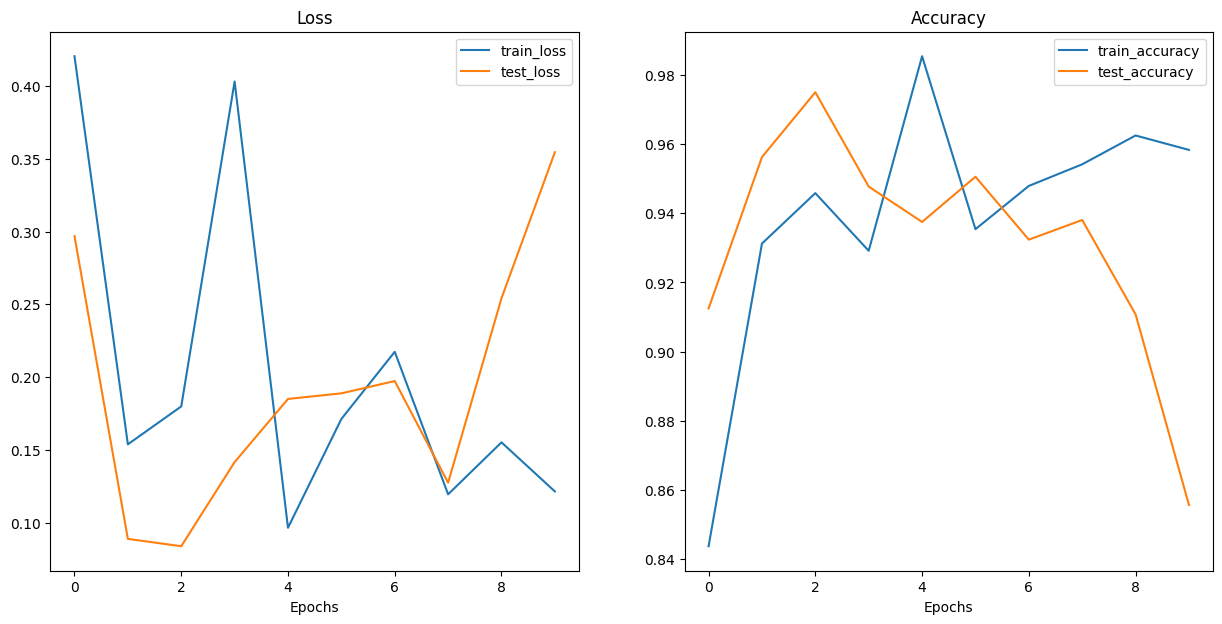

In [18]:
from helper_functions import plot_loss_curves
plot_loss_curves(modelo)

### 3.5 Salvando o modelo EffNetB2


In [19]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Descobrindo o tamanho do arquivo do modelo

Pq isso e importante?

Pq estamos lancando esse modelo pra ser usado em um app/mobile que pode ter limitacoes de recurcos computacionais. Assim se o modelo for muit grande (para os dispositivos em questao) ele pode nao rodar/ ter problemas ao rodar.


In [20]:
from pathlib import Path

#Pegando o tamanho em bytes e convertendo para mega
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Tamanho do modelo {round(pretrained_effnetb2_model_size, 2)}MB")

Tamanho do modelo 29MB


### 3.7 Estatisticas do extrator de caracteristicas da EffNetB2

In [21]:
#Contagem da quantidade de parametros
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
#Criando um dicionarios com os resultados do treinamento do modelo para posterior comparacao
effnetb2_stats = {"test_loss": modelo["test_loss"][-1],
                  "test_acc": modelo["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.3545991837978363,
 'test_acc': 0.8556818181818182,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4. Criando um extrator de caracteristicas usando o ViT

In [23]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

vit_transforms = vit_weights.transforms()

vit = torchvision.models.vit_b_16(weights=vit_weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 177MB/s]


In [24]:
for param in vit.parameters():
  requires_grad=False

In [25]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [26]:
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [27]:
vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3)
)

In [28]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [29]:
def create_vit(out_features:int=3, seed:int=42):
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  vit_transforms = vit_weights.transforms()

  vit = torchvision.models.vit_b_16(weights=vit_weights)

  for param in vit.parameters():
    param.requires_grad=False

  vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3)
    )

  return vit, vit_transforms

In [30]:
vit, vit_transform = create_vit(out_features=3,
           seed=42)
vit_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [31]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Criando os DataLoaders para a ViT

In [32]:
train_vit_dataloader, test_vit_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transform,
                                                                                       batch_size=32)
len(train_vit_dataloader), len(test_vit_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Treinando a ViT

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)


In [34]:
vit_results = engine.train(model=vit,
                           train_dataloader=train_vit_dataloader,
                           test_dataloader=test_vit_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5945 | train_acc: 0.8146 | test_loss: 0.2363 | test_acc: 0.9506
Epoch: 2 | train_loss: 0.2109 | train_acc: 0.9437 | test_loss: 0.1248 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.1507 | train_acc: 0.9563 | test_loss: 0.0940 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1203 | train_acc: 0.9646 | test_loss: 0.0787 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.1029 | train_acc: 0.9750 | test_loss: 0.0735 | test_acc: 0.9812
Epoch: 6 | train_loss: 0.0884 | train_acc: 0.9750 | test_loss: 0.0686 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0732 | train_acc: 0.9812 | test_loss: 0.0655 | test_acc: 0.9812
Epoch: 8 | train_loss: 0.0641 | train_acc: 0.9875 | test_loss: 0.0626 | test_acc: 0.9812
Epoch: 9 | train_loss: 0.0574 | train_acc: 0.9938 | test_loss: 0.0591 | test_acc: 0.9812
Epoch: 10 | train_loss: 0.0528 | train_acc: 0.9938 | test_loss: 0.0580 | test_acc: 0.9812


### 4.3 Plotando as curvas do treinamento

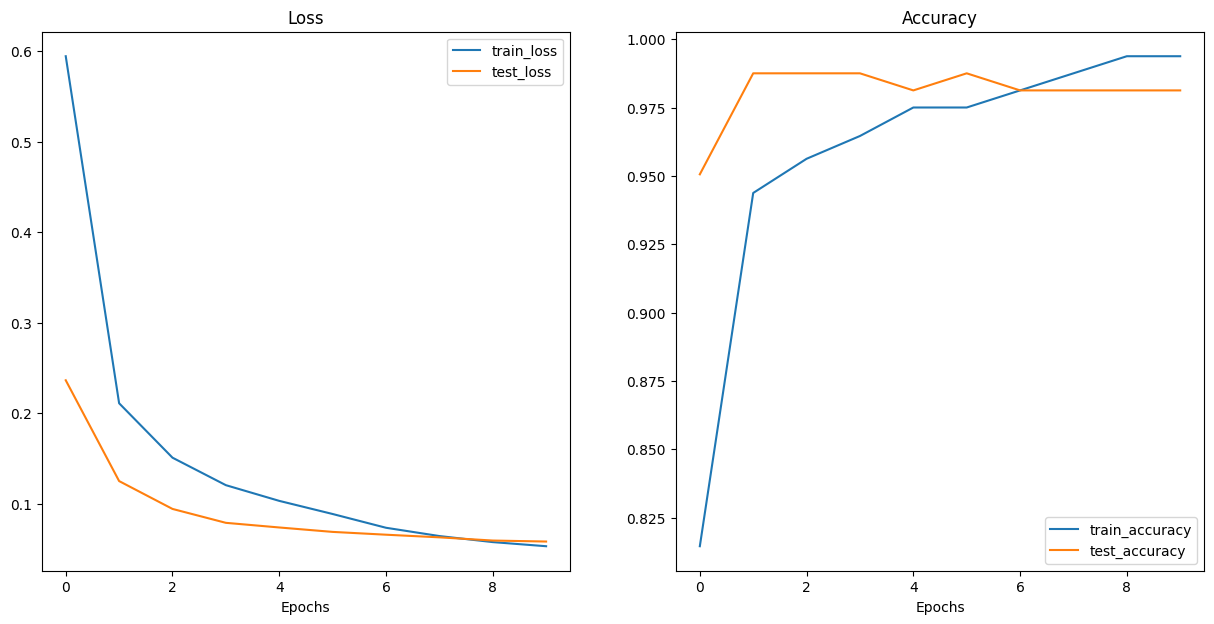

In [35]:
plot_loss_curves(vit_results)

### 4.4 Salvando a ViT

In [36]:
utils.save_model(model=vit,
                 target_dir='models',
                model_name="09_pretrained_vit_feature_extrator_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extrator_pizza_steak_sushi_20_percent.pth


### 4.5 Checando o tamanho do modelo ViT

In [37]:
tamanho_modelo= Path("models/09_pretrained_vit_feature_extrator_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f" size: {tamanho_modelo} mb")


 size: 327 mb


### 4.6 Estatisticas do modelo ViT

In [38]:
#Contagem da quantidade de parametros
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [39]:
vit_stats = {"test_loss" : vit_results["test_loss"][-1],
             "test_acc" : vit_results["test_acc"][-1],
             "number_of_parameters" : vit_total_params,
             "model_size (MB)": tamanho_modelo
             }
vit_stats

{'test_loss': 0.05798092894256115,
 'test_acc': 0.98125,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Realizando predicoes com os modelos treinados e conometrando

Objetivos
  * 95%+ Acc
  * 30+ FPS

Criterios do teste:

1. Passar pelas imagens de teste
2. Calcular quanto tempo cada modelo leva para realizar a predicao na imagem

In [40]:
from pathlib import Path

#PPEgando todos os aminhos dos dadoss de teste
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/219196.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/730464.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2307638.jpg')]

### 5.1 Criando a funcao para fazer teste em todo dataset

* `pred_and_store()`

1. Criar um funcao que receba uma lista de caminhos, um modelo pytorch, um transforms, lista das classes alvo, e um dispositivo.
2. Criar uma lista vazia, que ira receber todas as predicoes
3. PErcorrer sobre os caminhos dos dados (os proximos passos ocorreram dentro dest loop).
4. Criar um dicionario vazio para cada amostra (As stats de predicao irao aqui)
5. Pegar o caminho da amostra e a classe verdadeira do filepath
6. Comecar o tempo da predicao
7.  Abrir a imagem usando `PIL.Image.open(path)`.
8. Transformar a imagem para estar apta ao modelo.
9. Preparar o modelo para inferencia, mandar para o dispositivo alvo e acionar o modo `eval()`.
10. Ligar o torch.inference_mode() e passar a imagem alvo transformada para o modelo e performar o forward pass + calculo da pred prob + pred class.
11. Adicionar a pred prob + pred class ao dicionario do passo 4.
12. Encerrrar o timer, e adicionar o tempo decorrido ao dicionario.
13. Verificar se as classes preditas sao as verdadeiras.
14. Adiconar ao fim da lista as predicoes conforme vao ocorrendo
15. Devolver a list de dicionarios de predicoes.


In [41]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Dict, List

# 1.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  #2.
  pred_list = []

  #3.
  for path in tqdm(paths):

    # 4.
    pred_dict = {}

    # 5.
    pred_dict["image_path"] = path
    class_names = path.parent.stem
    pred_dict["class_names"] = class_names

    # 6.
    start_time = timer()

    # 7.
    img = Image.open(path)

    # 8.
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9.
    model = model.to(device)
    model.eval()

    # 10.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # 11.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    # 13.
    pred_dict["correct"] = class_names == pred_class

    # 14.
    pred_list.append(pred_dict)
  # 15. devolve a lista de dicionarios com as predicoes
  return pred_list

In [42]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaries
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

### 5.2 Realizando as predicoes e conometrando-as

Usando a `pred_and_store()`

Pontos chaves:
1. O dispositivo sera CPU, configurada manualmente (Pq nao se tem certeza que sempre havera uma GPU quando o medelo entrar em deploy)
2. Transforms - os modelo tem que estarem realizando as predicoes com os dados de teste que foram transformados para os repectivos modelos.

#### EffNetB2

In [43]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [44]:
effnetb2_test_pred_dicts[:2]


[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7268,
  'pred_class': 'pizza',
  'time_for_pred': 0.4559,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/219196.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9923,
  'pred_class': 'steak',
  'time_for_pred': 0.1977,
  'correct': True}]

In [45]:
#TRansformando o test_pred_dicts em um DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.7268,pizza,0.4559,False
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9923,steak,0.1977,True
2,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8705,steak,0.1250,True
3,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9806,steak,0.1198,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9905,steak,0.1159,True


In [46]:
#ChecaNDO O NUMERO DE PREVISOES CORRETAS
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,131
False,19


In [47]:
#Tempo medio de predicao
effnetb2_average_time_per_pred= round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"Tempo medio de predicao da EffNetB2: {effnetb2_average_time_per_pred}")


Tempo medio de predicao da EffNetB2: 0.1079


In [48]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.3545991837978363,
 'test_acc': 0.8556818181818182,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1079}

#### ViT

In [49]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu")
vit_test_pred_dicts[:2]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9851,
  'pred_class': 'steak',
  'time_for_pred': 0.6823,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/219196.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9945,
  'pred_class': 'steak',
  'time_for_pred': 0.3818,
  'correct': True}]

In [50]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9851,steak,0.6823,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9945,steak,0.3818,True
2,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7776,steak,0.3661,True
3,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9526,steak,0.3585,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9963,steak,0.3830,True


In [51]:
#ChecaNDO O NUMERO DE PREVISOES CORRETAS
vit_test_pred_df.correct.value_counts()

,count
correct,
True,147
False,3


In [52]:
#Tempo medio de predicao
vit_average_time_per_pred= round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"Tempo medio de predicao da ViT: {vit_average_time_per_pred} ")

Tempo medio de predicao da ViT: 0.412 


In [53]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05798092894256115,
 'test_acc': 0.98125,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.412}

In [54]:
effnetb2_stats

{'test_loss': 0.3545991837978363,
 'test_acc': 0.8556818181818182,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1079}

## 6. Comparando os resultados dos modelos

In [55]:
#transformando os dict em dataframws
df = pd.DataFrame([effnetb2_stats, vit_stats])

#Add uma coluna de nome
df["model"] = ['EffNetB2', "ViT"]

#Converte acc em porcentagem
df["test_acc"] = round(df["test_acc"] * 100, 2)

In [56]:
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.354599,85.57,7705221,29,0.1079,EffNetB2
1,0.057981,98.12,85800963,327,0.4120,ViT


Qual modelo eh o melhor?
* test_loss (menos e melhor) -ViT
* test_acc (mais e melhor) -ViT
* number_of_parameters (geralmente menor e maior*) - se um modelo tem mais parametros, geralmente demora mais para computr
  * *as vezes modelos com mais parametros ainda conseguem computar mais rapido
* model_size (MB) - EffNetB2 (PAra o nosso caso que o deploy sera para mobile, geralmente menor eh melhor)
* time_per_pred_cpu (menos e melhor, sera altamente dependendo do hardware que esta rodando

Os dois modelos falharam em atingir o objetivo de 30+FPS... Com tudo se pode so tenatr e usar o EffNetB2 e ver como ele se sai

In [57]:
#Comprando ViT com EffNetB2
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.163511,1.146664,11.135432,11.275862,3.81835


### 6.1 Visualizando o tradeoff Velocidade X Performace

PAra comparar os dois features extrator de maneira visual:

1. Criar um scatter plot usando o datafrade para comprar a acc de teste e o tempo de predicao entre EffNetB2 X ViT.
2. Add titulos e rotulos pra grafico ficar mais legivel.
3. Anotar os amostras no grafico
4. Criar a legende para o grafico com base no tamanho dos modelos (MB)

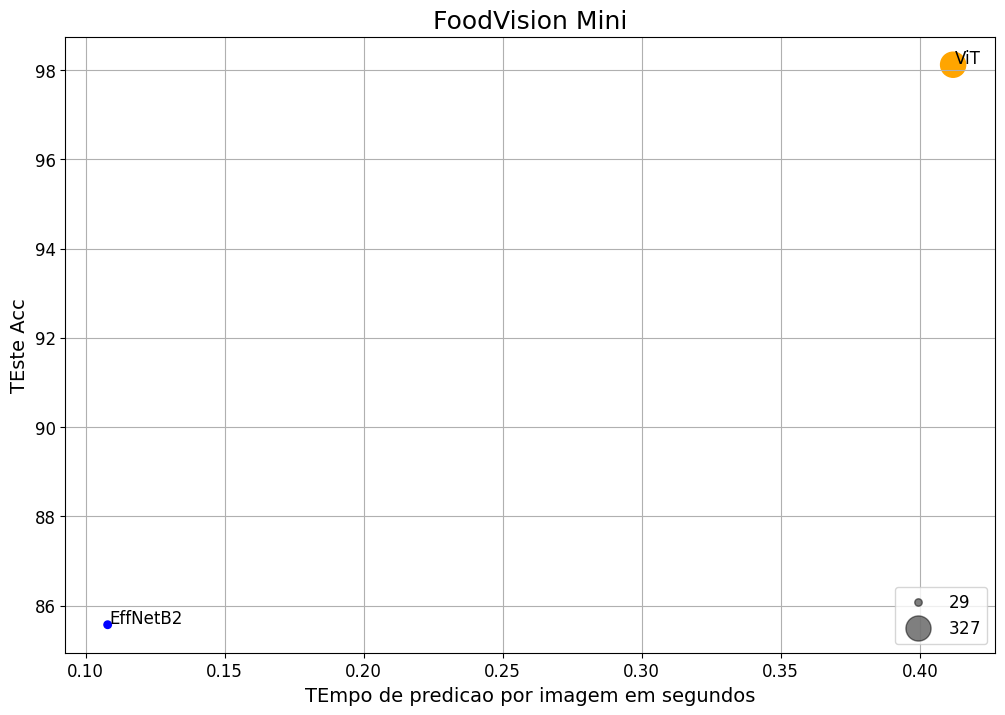

In [58]:
# 1. Criar grafico para comparacao do DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Titulos e labels
ax.set_title("FoodVision Mini", fontsize=18)
ax.set_xlabel("TEmpo de predicao por imagem em segundos", fontsize=14)
ax.set_ylabel("TEste Acc", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3.
for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
              size=12)

# 4. Criando as legendas baseada nos tamanho dos modelos
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              fontsize=12)


plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

plt.show();

## 7. Dando vida ao FoodVision Mini Usando uma demo do Gradio

EffNetB2 foi escolhido com base nos criterio

In [1]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.3 MB/s eta 0:00:00
Gradio version: 5.4.0


### 7.1 Gradio Overview

PQ usar? Pra criar um mvp do modelo que possa ser testado por outras pessoas.



```
inputs -> fucntion/model -> outputs
```



### 7.2  Criando uma funcao para mapear nossas entradas e saidas

In [59]:
effnetb2 = effnetb2.to("cpu")

#Checando se foi para o dispositivo
next(iter(effnetb2.parameters())).device

device(type='cpu')

A funcao `predict()` ira fazer:



```
Imagem de comida -> Modelo (EffNetB2) -> [Classe da comida e tempo de predicao]
```



In [60]:
from typing import Dict, Tuple

def predict(img) -> Tuple[Dict, float]:

  #Comeca o time
  start_time = timer()

  #Transforma a imagem para o padrao EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) #unqueeze = add uma dimensao batch na posicao 0

  #Colocando o model em eval
  effnetb2.eval()
  with torch.inference_mode():

    #Pasando a imagem transformada pelo modelo de devolvendo os logist em pred prob
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Criando a label de predicao e o dicionario
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #Calculando o tempo de predicoa
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return pred_labels_and_probs, pred_time

In [61]:
import random
from PIL import Image

#Pega em lista todos os caminhos da pasta test
test_data_path = list(Path(test_dir).glob("*/*.jpg"))
test_data_path

#Selecionando a imagem de test aleatoriamente
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

#Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predizendo a imagem de caminho: {random_image_path}\n")

#Prevendo e mostrando o dict e tempo
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predizendo a imagem de caminho: data/pizza_steak_sushi_20_percent/test/pizza/476421.jpg



NameError: name 'pred_probs' is not defined

### 7.3 Criando uma lista de exemplos de Imagens

In [ ]:
#Criando a lista de exemplos
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

### 7.4 Contruindo uma interface com o gradio

In [ ]:
# Criando um titulo, descricao e artigo
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?